## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [156]:
import string
import os
import numpy as np

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [157]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In [158]:
text[:1]

['  From fairest creatures we desire increase,\n']

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [159]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
sonnets = "".join(text).lower()

assert len(sonnets) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(sonnets) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [160]:
with open('evgeniy-onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

In [161]:
text[:5]

['александр сергеевич пушкин\n',
 'евгений онегин\n',
 'роман в стихах\n',
 '1\n',
 'мысля гордый свет забавить\n']

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [162]:
# Join all the strings into one and lowercase it
# Put result into variable text.

onegin = "".join(text).lower()
tokens = list(set(onegin))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [163]:
# dict <index>:<char>
# Your great code here

# dict <char>:<index>
# Создадим 2 словаря для того, чтобы кодировать токены при переводе предложений в матрицу и обратно
token_to_idx = {k: v for k, v in zip(tokens, range(len(tokens)))}
idx_to_token = {k: v for k, v in zip(range(len(tokens)), tokens)}

In [164]:
len(token_to_idx)

44

In [165]:
len(text[0])

27

Оценю распределение длин строк чтобы при генерации и кодировании использовать максмиальную длину как констранту

max length = 555


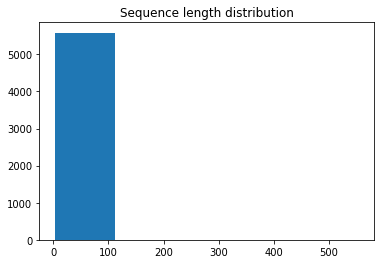

In [166]:
lens = [len(line) for line in text]

MAX_LENGTH = max(lens)
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(lens,bins=5);

In [187]:
# Позиамствую с семинара код,который перевод предложение в индексы
def to_matrix(sentences, max_len = None, dtype='int32', batch_first=True):
    max_len = max_len or max(map(len, sentences))
    sentences_ix = np.zeros([len(sentences), max_len], dtype)

    for i in range(len(sentences)): 
        line_ix = [token_to_idx[c] for c in sentences[i]] 
        sentences_ix[i, :len(line_ix)] = line_ix[:max_len]
    if not batch_first: 
        sentences_ix = np.transpose(sentences_ix) #Транспонируем

    return sentences_ix

In [188]:
to_matrix(['я помню чудное мгновенье'], max_len = None, dtype='int32', batch_first=True)

array([[13,  8, 20, 22, 23, 24, 10,  8, 14,  9, 11, 24, 22,  7,  8, 23,
        19, 24, 22, 12,  7, 24, 32,  7]], dtype=int32)

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [193]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import random
device = 'cpu'

In [194]:
# Беру с лекции код, который описывает модель RNN и ее обучение (может он и не ванилла)
# https://github.com/girafe-ai/ml-course/blob/master/week0_09_embeddings_and_seq2seq/week09_seq2seq_rnn_practice_solved.ipynb

embed = nn.Embedding(4,2)
sample = torch.LongTensor([2])
next(embed.parameters())

class CharRNNCell(nn.Module):
    '''
    Класс создает модель архитекуры RNN, 
    инициализирует начальное состояние скрытого слоя и задает правило для обучения
    '''
    def __init__(self, num_tokens=len(tokens), embedding_size=64, rnn_num_units=512):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens) 
        
    def forward(self, x, h_prev):
        #Преобразуем каждый токен в вектор эмбеддингов
        x_emb = self.embedding(x)
        #Тут работает реккурентность - соединяем эмбеддинг текущего токена со скрытым состочнием,
        #накопленным на предыдущем шаге
        x_and_h = torch.cat([x_emb.to(device), h_prev.to(device)], dim=-1)
        h_next = self.rnn_update(x_and_h)
        #нелинейность
        h_next = torch.tanh(h_next)
        #логиты = еще одна нелинейность для получения вероятностей
        logits = self.rnn_to_logits(h_next) 
        return h_next, F.log_softmax(logits, -1) 
        
    
    def initial_state(self, batch_size): #Инициализация hidden_state_{0}  
        return torch.zeros(batch_size, self.num_units, device=device, requires_grad=True)

In [195]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters(), lr=1e-3) # такой стандарный lr возьмем для обеих моделей 

def rnn_loop(char_rnn, batch_ix):
    batch_size, _ = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0, 1):
        hid_state, logp_next = char_rnn(x_t, hid_state)
        logprobs.append(logp_next) 
    return torch.stack(logprobs, dim=1) 

Plot the loss function (axis X: number of epochs, axis Y: loss function).

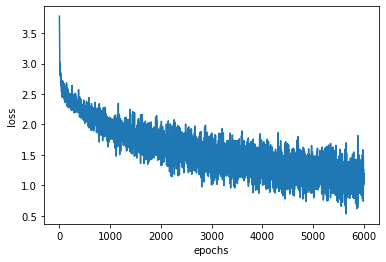

In [196]:
loss_history = []

for i in range(6000): #6000 эпох возьмем для обеих моделей
    sub_str = []
    
    # собираем каждый батч - берем подвыборку из случайного места длиной MAX_LENGTH (беру большие куски текста подряд, чтобы научить модель выдавать осмысленный текст)
    
    idx = random.randrange(0, len(onegin) - MAX_LENGTH + 1)        
    sub_str.append(onegin[idx : (idx + MAX_LENGTH)]) 
    
    batch_ix = to_matrix(sub_str, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    loss = criterion(predictions_logp.contiguous().view(-1, len(tokens)), actual_next_tokens.contiguous().view(-1))
    
    loss.backward()
    opt.step()
    opt.zero_grad()
        
    loss_history.append(loss.data.cpu().numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(loss_history)
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()

Визуально видно, что модель обучается, хотя есть существенные колебания от батча к батчу. В итоге после 6000 тыс эпох лосс на уровне 1.

In [197]:
seed_phrase = 'я помню чудное мгновенье'
#MAX_LENGTH = 555
def generate_sample(char_rnn, seed_phrase=seed_phrase, max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    x_sequence = [token_to_idx[token] for token in seed_phrase] 
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device) 
    hid_state = char_rnn.initial_state(batch_size=1)
    
    
    for i in range(len(seed_phrase) - 1):
        hid_state, out = char_rnn(x_sequence[:, i], hid_state)
    
    for _ in range(max_length - len(seed_phrase)):
        hid_state, out = char_rnn(x_sequence[:, -1], hid_state) 
        p_next = F.softmax(out / temperature, dim=-1).data.cpu().numpy()[0]        
        next_ix = np.random.choice(len(tokens), p=p_next)        
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)        
        x_sequence = torch.cat([x_sequence, next_ix], dim=1) 
   
    result = ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0] if tokens[ix] != "_"])
    
    return result

In [198]:
# An example of generated text.
print(generate_sample(char_rnn, seed_phrase='я помню чудное мгновенье'))

я помню чудное мгновенье
как падвееная злостям
в ней гатело ей злокиц
из полдень много броша к том55
зареметы молодых раставлись
как страх пофолное толким
ведина быть она тихотовушал
примодной сам сид иной дни
такопусь от в общий решено
иль сказал уж желания
перенесено ей вашей укружена
вот это ж она женских был
по клоки тайные лиским
нило к тахной и двора
их отдара шавло б татьяне
но познел воспелкее мученья
хотя кровлощи скаль тисок
и окнам рад идет она
пора его нежный уморы
и радовенное тутя света
меня о


Обсуждение результатов:

1. Цифры внтури текста, модель не выучила, что цифра разделяют строфы (правда только 1 раз)

2. Вообще это не похоже не кашу из букв, есть как реальные слова, так и вымышленные, но осмысленного текста не получилось.

3. Длина строки +- стабильная и похоже на Пушкина.

Пробовала по-разному дорабатывать модель, например, пробовала убирать софтмакс на выходе, так как прочитала, что  внутри NLLLoss уже усть софтмакс, а Радослав на лекции говорил, что два софтмакса ухудшают способность к обучению. Но появлялись отрицательные значения лосса на обучении, поэтому софтмакс вернула. Хорошо сказалось на качестве генерации решение брать для батча подвыборку подряд, а не собирать из разных кусочков - выравнялся размер строки, каша из букв превратилась в слова.
Возможные причины невысоко качества модели: мало данных (только Евгений Онегин) и модель слишком простая, чтобы уловить паттерны русского языка

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [199]:
# Your beautiful code here
class CharLSTMCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), emb_size=64, lstm_num_units=512):
        super(self.__class__, self).__init__()
        self.num_units = lstm_num_units 
        self.emb = nn.Embedding(len(tokens), emb_size) 
        self.lstm = nn.LSTM(emb_size, self.num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(self.num_units, num_tokens) 

    def forward(self, x, hidden=None):
        h_seq, hidden = self.lstm(self.emb(x), hidden)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, hidden 

    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, device=device, requires_grad=True)

In [200]:
char_lstm = CharLSTMCell().to(device)
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_lstm.parameters(), lr=1e-3)

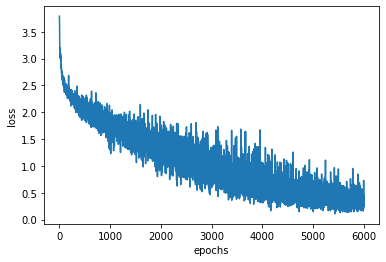

In [201]:
lstm_loss_history = []

for i in range(6000): 
    sub_str = []
    # собираем каждый батч - берем подвыборку из случайного места длиной MAX_LENGTH
    idx = random.randrange(0, len(onegin) - MAX_LENGTH + 1)        
    sub_str.append(onegin[idx : (idx + MAX_LENGTH)]) 
    
    batch_ix = to_matrix(sub_str, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq, _ = char_lstm(batch_ix) 
    
    predictions_logp = logp_seq[:, :-1] 
    actual_next_tokens = batch_ix[:, 1:]
    #подсчёт лосса
    loss = criterion(predictions_logp.contiguous().view(-1, len(tokens)), actual_next_tokens.contiguous().view(-1))
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    loss_value = loss.data.cpu().numpy()
    
    lstm_loss_history.append(loss.data.cpu().numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(lstm_loss_history)
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()

Характер сходимости модели (снижение лосса) примерно такой же, как у RNN, но более плавный, вспелексов и расхождений нет, абсолютное значение ошибки на 6000 эпох меньше - модель лучше обучилась, лосс меньше 0.5. Сравним, влияет ли это положительно на результаты генерации

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [202]:
seed_phrase='я помню чудное мгновение'
def generate_sample_lstm(char_lstm, seed_phrase=seed_phrase, max_length=555, temperature=1.0):
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    
    h_state = torch.zeros(1, 1, char_lstm.num_units, device=device) 
    c_state = torch.zeros(1, 1, char_lstm.num_units, device=device) 

    
    for i in range(len(seed_phrase) - 1):
        _, (h_state, c_state) = char_lstm(x_sequence[:, i].unsqueeze(0), (h_state, c_state))

    for i in range(max_length - len(seed_phrase)):
        logits, (h_state, c_state) = char_lstm(x_sequence[:, -1].unsqueeze(0), (h_state, c_state))
        p_next = F.softmax(logits / temperature, dim=-1).data.cpu().numpy()[0]
        next_ix = np.random.choice(len(tokens), p=p_next.ravel())
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    result = ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0] if tokens[ix] != "_"])
    return result

In [203]:
# Text generation with different temperature values here
result = generate_sample_lstm(char_lstm, seed_phrase='я помню чудное мгновенье', max_length=555, temperature=0.1)
print('Temp 0.1\n', result)

Temp 0.1
 я помню чудное мгновенье
не ты ль с отрадой и любовью
слова надежды мне нет его
и страсбургский бразда его
и пел и страсть его лежит
погибну таня гостит
а между тем две три страницы
пустые бредни небылицы
опасные для сердца дев
он пропусь на свете надоел
и все отволясь в наши дни
что охна на наше дальной
увилься в вашах флагородный
короткий вызов иль картель
учтиво с ясностью холодной
звал друга ленский на дуэль
онегин с первого движенья
к послу такого порученья
оборотясь без трудов деле
и начилась их собранье
где прыграммать не могла
лишь смертной 


In [204]:
result = generate_sample_lstm(char_lstm, seed_phrase='я помню чудное мгновенье', max_length=555, temperature=0.2)
print('Temp 0.2\n', result)

Temp 0.2
 я помню чудное мгновенье
не ты ль с отрадой и любовью
слово лаской замечу бело
но мне теперь не до него
лета к суровой прозе клонят
лета шалунью рифму гонят
и я со вздохом признаюсь
за ней ленивей волочусь
перу старинной нет охоты
марать летучие листы
другие хладные моды
наука не преданьям стремны
все в них на старый образец
у тетушки княжны елены
все тот же ль он иль светит ей
но кушать он и пера
и слез и рифм
представь меня ты шутишь нету
я рад когда же хоть сейчас
они с оставленные креты
порывы девственным огнем
чуть отрок от него любезна
я не ро


In [205]:
result = generate_sample_lstm(char_lstm, seed_phrase='я помню чудное мгновенье', max_length=555, temperature=0.5)
print('Temp 0.5\n', result)

Temp 0.5
 я помню чудное мгновенье
не знаю прелестью своей
она как ландыш потаешь коня
ну то мой жизни поколом
вдали веков сердечных друг
приятный жребий повелей
все тот же трепетной рукой
одежды край подметился мил
и после мог он пеньем
был простой упрямые снова
по трубках в бедный любимые
все полно и что ж ейей
певерный в бранта не хотел
доверчивость души невине
и постелий рочки на дихне
давал он что ж его лету
как мы ни билось другом
когда ж начну я вольный бег
пора покинуть скучный брег
мне не находит горем
и все евгений на уме
и в ней и блажен хоть невин


In [206]:
result = generate_sample_lstm(char_lstm, seed_phrase='я помню чудное мгновенье', max_length=555, temperature=1.0)
print('Temp 1.0\n', result)

Temp 1.0
 я помню чудное мгновенье
не ты ля мне бьют толпа был друзья
поднять основленной ленский
весна слушала с ольгою столов
непрясь своей заблужительных
непоступил с уж и везде женой
и безореду творе лицу
потобой мне читатель мой
заняться стал со сквозь собой
иль вечный каминар и путьм
веселью что евгений
он вечно ты жена и света
красавиц модных модных чув
в балашенья плененный шум
когда безмолвно юним своим
унижу ли страстной девы
с ней оборотельно оред
и край одежды целовамой
вдруг мысль в журной и своей
для гости вслед зарецкий романа
в остохот бродить


In [207]:
result = generate_sample_lstm(char_lstm, seed_phrase='я помню чудное мгновенье', max_length=555, temperature=2.0)
print('Temp 2.0\n', result)

Temp 2.0
 я помню чудное мгновеньем
его ревом спремлющей
вражду оперсего мельку
чтоб тосне тогскосет
не холить в земле рав нед
окнемся никогда спатиной
это быша тень беспечно
а тимя свится ходпля слова
пора поътынные вскук
пугами живло онегин вмосленная
дуашикок мнерим индевь
да что сплинук плетит а23
он одекстов жребием племять с дерьмгицое
играми хезжает5 одугин двурный лац
на алки машурю вновь
яна
ужизнь обы был ды жада
места
уж чайдеки5 времяти неслик
он подибать ня ушлых лет
тая беспошла по молвую
умиленья взвесены
и невсем ручею думотой
узнало вряз найм


Обсуждение результатов генерации lstm моделт:

1. Размер строки досточно стабильный, похожий на Пушкина (то есть вероятностное распределение на PAD неплохо лучше обучено, как и у RNN)

2. Появилась структура исходного текста - строфы, разделенные числами

3. Слова как правило существующие, иногда придуманное, но по правилам русского языка. Но смысла в фразах все еще мало(

Выводы:
1) Модель RNN и LSTM обучались на одинаковых данных с одинаковым числом эпох и шагом обучения.
При этом если сравнивать результат генерации ни одна не дотягивает до "второго Пушкина", но однако у LSTM получился меньше лосс, что можно связать с улучшением качества генерации (Иногда строчка-две бывают прямо как из Онегина, если дать больше данных, то может и обучится неплохо). Похоже на "хливкие шорьки" у Льюиса Керролла)

2) Влияние температуры на результат генерации следующий: при низкой температуре модель выдает реально существующие слова или слова выдуманные, но составленные по правилам русского языка (можно угадать часть речи).
При повышении температуры генерация становится более рандомной, а именно: у нас с большей вероятностью выберется символ с не максимальным логитом. При использовании LLM повышение температуры

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [209]:
# Сохранение модели тоже беру у Радослава
# Saving and loading code here
torch.save(char_lstm.state_dict(), 'char_lstm.pth')

new_lstm = CharLSTMCell()
new_lstm.load_state_dict(torch.load('char_lstm.pth'))

result = generate_sample_lstm(new_lstm, seed_phrase='давай попробуем еще раз', max_length=555, temperature=0.1)
print(result)

давай попробуем еще разбола
затем что он все дворажденье
одно девы простодушной
что слезу приносят и грандистой
под ним как начинает капать
весенний дождь на свете недвижи
да сам в деревню в том уверен
и думать он меня любил
он мне единой посвятил
рассвет печальный жизни бурной
сердечный друг желанный друг
приятный жребий своей
любви модных и без слова
при как он ямбал и душа
без слово дрожит в летей
и свет ее с улыбкой встретил
успех нас первый окрылил
старик державин нас заметил
и в молчаливом кабинете
забыв на время все на свете
осталась наконец 


Вообще задание очень интересное, но по мне - сложное. Потратила много времени, чтобы разобрать каждую строчку и разобраться с ошибками,которые все равно вылезают, хотя бОльшая часть кода берется из ноутбуков, которые были на лекции/семинаре.

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)